# Разрабокта модели машинного обучения для предсказания закрытия стартапа


**Описание проекта**:
На основании доступных данных о стартапах, функционировавших с 1970 по 2018 годы предсказать их вероятности закрытия. Данные содержат как реальные, так и синтетически сгенерированные признаки. Обучение и расчет метрик производится на обучающей выборке, также есть отложенная неразмеченная выборка для загрузки на платформу kaggle.

**Цель проекта**:
Разработать модель машинного обучения, которая будет предсказывать вероятность закрытия стартапов на основе исторических данных.

**Ход исследования**:
- **Подготовка даннных**: загрузка и ознакомление с данными. Оценка структуры и качества данных.
- **Предварительная обработка**: обработка пропущенных значений, корректировка типов данных, устранение дубликатов.
-  **Анализ данных (EDA)**: исследовательский анализ признаков, выявление закономерностей, аномалий и особенностей распределения. Разработка новых признаков при необходимости.
- **Корреляционный анализ**: изучение взаимосвязей между признаками, оценка мультиколлинеарности.
Отбор финального набора обучающих признаков.
- **Разработка модели** прогнозования закрытия стартапа: обучение нескольких моделей, оценка их качества и анализ результатов.
- **Выбор лучшей модели**: использование метрики F1-score для оценки результатов, подбор гиперпараметров, сравнение моделей.
- **Анализ важности признаков**: определение значимости различных факторов, влияющих на предсказание модели.
- **Формирование рекомендаций**: создание рекомендаций по отбору стартапов для инвесторов.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap
import phik

from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import (OneHotEncoder,
                                   LabelEncoder,
                                   StandardScaler,
                                   MinMaxScaler)
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import f1_score 

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

#Установка единого формата данных
pd.options.display.float_format = '{:,.3f}'.format
pd.options.mode.chained_assignment = None

# Установка опции для отображения максимальной ширины столбца
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка данных

In [2]:
dataset = pd.read_csv('data/kaggle_startups_train_28062024.csv', parse_dates=['founded_at',
                                                                              'first_funding_at',
                                                                              'last_funding_at',
                                                                              'closed_at'])
display(dataset.head(2))
dataset.info()
display(dataset.describe())

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,"828,626.000",operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,"42,935,019.000",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
count,"42,447.000","52,516.000",52516,52516,52516,4917
mean,"18,247,480.657",1.741,2008-11-04 09:44:16.196206848,2011-07-17 04:45:33.247010304,2012-06-27 16:29:42.313961472,2012-01-16 16:14:21.012812544
min,1.000,1.000,1970-02-05 00:00:00,1977-05-15 00:00:00,1977-05-15 00:00:00,1983-10-06 00:00:00
25%,"336,027.500",1.000,2006-10-01 00:00:00,2009-10-12 00:00:00,2011-02-01 00:00:00,2009-09-18 00:00:00
50%,"2,000,000.000",1.000,2010-10-01 00:00:00,2012-07-23 00:00:00,2013-08-30 00:00:00,2012-09-15 00:00:00
75%,"10,000,000.000",2.000,2013-01-01 00:00:00,2014-04-01 00:00:00,2014-11-17 00:00:00,2015-04-23 00:00:00
max,"30,079,503,000.000",19.000,2016-04-02 00:00:00,2015-12-05 00:00:00,2015-12-07 00:00:00,2017-10-21 00:00:00
std,"187,117,301.321",1.375,NaN,NaN,NaN,NaN


<b>Вывод по разделу "Загрузка данных"</b>

- Датасет содержит 52516 записей, типы данных сответствуют информации в таблице.
- Имена полей соответствуют принятому обозначению и не требуют переименования.
- Целевая переменная `status` категориальная, перед подачей в модель потребуется кодирование.
- Датасет содержит несколько переменных в формате дат, которые неудобно для использования модели. В дальнейшем можно ввести синтетические перемеенные, отражающие информацию в датах (например, количество дней от основания до первого раунда инвестиций и т.д.)
- Данные содержат пропуски, которые будут обработаны на следующем этапе.
- Количественные признаки лежат в различных диапазонах, перед подачей в модель необходимо масштабиование.
- Среднее и медианное значения в поле `funding_total_usd` значительно отличаются, что может говорить о наличии выбросов и аномалий.

## Предобработка данных

Проверим данные на наличие пропусков, явных и неявных дубликатов.

In [3]:
def data_check(data, id_column = 'id'):
    '''Проверка на наличие пропусков и количество уникальных значений категориальных признаков'''
    for column in data.columns:
        if data[column].isna().sum() > 0:
            print(f'В поле {column} есть пропуски в данных: {data[column].isna().sum()} строк')
        if data[column].dtype == 'object':
            data[column] = data[column].str.lower()
            print(f'Количество уникальных значений в поле "{column}":', len(data[column].unique()))   
    print('______________')
    '''Проверка на наличие явных дубликатов'''
    if data.duplicated().sum() > 0:
        print(f'В данных есть явные дубликаты: {data.duplicated().sum()} строк')
    else:
        print('В данных нет явных дубликатов')
    print('______________')
    if data[id_column].nunique() == data.shape[0]:
        print('Все значения в поле с идентификатором уникальны')
    else:
        print('В поле с идентификатором есть дубликаты')

In [4]:
data_check(dataset, id_column = 'name')

В поле name есть пропуски в данных: 1 строк
Количество уникальных значений в поле "name": 52473
В поле category_list есть пропуски в данных: 2465 строк
Количество уникальных значений в поле "category_list": 22106
В поле funding_total_usd есть пропуски в данных: 10069 строк
Количество уникальных значений в поле "status": 2
В поле country_code есть пропуски в данных: 5502 строк
Количество уникальных значений в поле "country_code": 135
В поле state_code есть пропуски в данных: 6763 строк
Количество уникальных значений в поле "state_code": 301
В поле region есть пропуски в данных: 6359 строк
Количество уникальных значений в поле "region": 1037
В поле city есть пропуски в данных: 6359 строк
Количество уникальных значений в поле "city": 4478
В поле closed_at есть пропуски в данных: 47599 строк
______________
В данных нет явных дубликатов
______________
В поле с идентификатором есть дубликаты


### Поле `closed_at`

In [5]:
display(dataset[(dataset['closed_at'].isna())&(dataset['status'] == 'closed')])
print(dataset[(~dataset['closed_at'].isna())&(dataset['status'] == 'closed')]['status'].count())

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


4917


Самое большое количество пропущенных данных в поле `closed_at`, которое содержит данные о дате закрытия стартапа. Это поле напрямую связано с целевой переменной и для действующих стартапов содержит пропуск. **Переменная `closed_at` - это data leak (утечка данных)**. Эти данные не будут доступны на момент принятия решения о вложении средств в стартап, поэтому использовать переменную при моделировании некорректно. При обучении исключим это поле из датасета.

### Поле `name`

В поле `name` есть дубликаты, при этом явных дубликатов в данных нет. Вполне вероятно, что существует несколько компаний с одинаковым называнием. Посмотрим на дубли и пропуск внимательнее.

In [6]:
dataset[dataset.duplicated(subset='name', keep=False)].head(2)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
242,shift,bicycles,"13,550,000.000",operating,usa,nv,las vegas,las vegas,3,2012-06-17,2013-03-29,2014-05-16,NaT
257,tribe,brand marketing|content|marketplaces|social media,"581,435.249",operating,aus,7,melbourne,south melbourne,1,2015-06-02,2015-04-01,2015-04-01,NaT


In [7]:
display(dataset[dataset['name'] == 'shift'])
display(dataset[dataset['name'] == 'tribe'])

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
242,shift,bicycles,"13,550,000.000",operating,usa,nv,las vegas,las vegas,3,2012-06-17,2013-03-29,2014-05-16,NaT
51577,shift,advertising|consumer goods|facebook applications|social media,"14,000,000.000",operating,usa,ca,los angeles,santa monica,4,2010-01-01,2011-02-01,2013-12-10,NaT


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
257,tribe,brand marketing|content|marketplaces|social media,"581,435.249",operating,aus,7,melbourne,south melbourne,1,2015-06-02,2015-04-01,2015-04-01,NaT
49155,tribe,social media,"9,350,000.000",operating,usa,ca,sf bay area,los gatos,2,2003-01-01,2003-11-26,2006-02-24,NaT


In [8]:
dataset.query('name.isna()')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,NaN,startups,"25,000.000",closed,usa,or,"portland, oregon",portland,1,2011-10-01,2012-03-01,2012-03-01,2013-06-03


Данные для стартапов с одинаковыми названиями сильно отличаются. Скорее всего это разные компании. Поле `name` не будет использоваться в обучении, т.к. по сути являетcя идентификатором, оставим поле без изменений. Пустое значение заменим на 'MISSING'.

In [9]:
dataset['name'].fillna('missing', inplace=True)

### Поле `category_list`

Восстановить значения для пропущенных записей в поле `category_list` невозможно, поэтому заменим на 'MISSING'.

In [10]:
dataset['category_list'].fillna('missing', inplace=True)

Также в поле `category_list` большое количество уникальных значений за счет комплексной записи категории. Для снижения размерности в данном случае можно использовать различные методы, включая кластеризацию через векторизацию (например, TF-IDF). С точки зрения интерпретируемости для бизнеса, самым простым будет отобрать укрупненные категории, которые максимально "покрывают" отрасли стартапов и заменить на них текущие значения. Попробуем реализовать этот вариант.

In [11]:
dataset['categories'] = dataset['category_list'].str.lower().str.split('|').astype('object')
dataset[['categories', 'category_list']].head(2)

,categories,category_list
0,"[online reservations, restaurants]",online reservations|restaurants
1,"[manufacturing, medical, medical devices]",manufacturing|medical|medical devices


In [12]:
all_categories = []

for row in dataset['categories']:
    for word in row:
        all_categories.append(word)

Отберем 70% наиболее часто встречающихся категорий.

In [13]:
categories_freq = pd.Series(all_categories).value_counts(normalize=True).cumsum()
selected_categories = categories_freq[categories_freq <= 0.7].index.tolist() 
print('Количество отобранных категорий:', len(selected_categories))

Количество отобранных категорий: 98


Нам удалось значительно снизить количество категорий (до 98 значений). После кодирования получится 98+ столбцов, что в принципе допустимо для большинства моделей. Если наблюдение не подходит ни под одну из отобранных категорий, заменим значение на 'ELSE'. Т.к. аналогичную обработку необходимо будет применять к отложенной выборке, оформим преобразование в функцию.

In [14]:
def bigger_categories(data, column, categories):
    data_copy = data.copy()

    for i, row in data_copy.iterrows():
        bigger_category = 'else'
        for category in row[column]:
            if category in categories:
                bigger_category = category
                break
        data_copy.at[i, column] = bigger_category
    return data_copy

In [15]:
dataset = bigger_categories(dataset, column='categories', categories= selected_categories)
dataset[['categories', 'category_list']].head()

,categories,category_list
0,restaurants,online reservations|restaurants
1,manufacturing,manufacturing|medical|medical devices
2,biotechnology,biotechnology
3,health care,health care
4,manufacturing,manufacturing


In [16]:
dataset['categories'].unique()

array(['restaurants', 'manufacturing', 'biotechnology', 'health care',
       'mobile', 'analytics', 'software', 'semiconductors',
       'clean technology', 'missing', 'technology', 'customer service',
       'finance', 'messaging', 'else', 'social media',
       'enterprise software', 'cloud computing', 'entertainment',
       'internet', 'advertising', 'fitness', 'consumer goods', 'media',
       'apps', 'enterprises', 'travel', 'e-commerce', 'collaboration',
       'information technology', 'medical', 'big data analytics',
       'business services', 'sports', 'curated web', 'security',
       'fashion', 'real estate', 'social network media', 'big data',
       'music', 'events', 'medical devices', 'health and wellness',
       'automotive', 'education', 'digital media', 'pharmaceuticals',
       'games', 'hardware + software', 'services', 'saas', 'fintech',
       'consulting', 'design', 'brand marketing', 'android', 'video',
       'consumer electronics', 'content', 'crm', 'trans

При изучении списка явно видно, что часть категорий можно еще укрупнить по отраслям. Например, 'brand marketing' и 'internet marketing' можно объединить в категорию 'marketing'. Попробуем составить словарь для некоторых очевидных подкатегорий.

In [17]:
category_mapping = {
    'health care': ['biotechnology', 'health care', 'medical', 'medical devices',
                    'health and wellness', 'pharmaceuticals', 
                    'health care information technology',
                    'health diagnostics'],
    'mobile': ['mobile', 'android', 'ios', 'iphone', 'mobile commerce'], 
    'retail': ['customer service', 'e-commerce', 'online shopping', 'marketplaces', 'retail',
               'social commerce'],
    'marketing':['advertising', 'fitness', 'design', 'brand marketing',
                 'internet marketing', 'sales and marketing'],
    'it_technology':['software', 'analytics', 'semiconductors', 'cloud computing', 
                  'big data analytics', 'technology', 'internet', 'enterprise software',
                  'information technology', 'apps', 'hardware + software', 'saas',
                  'web hosting', 'location based services', 'web development',
                  'search', 'curated web', 'big data'],
    'entertainment':['media', 'social media', 'music', 'video', 'entertainment',
                    'video streaming', 'news', 'photography', 'events', 
                    'content', 'publishing', 'telecommunications', 'facebook applications',
                    'social network media', 'digital media', 'messaging', 'games'],
    'finance_and_business':['finance', 'fintech', 'financial services', 'payments', 'b2b',
               'business services', 'consulting', 'service providers', 
               'crm', 'crowdsourcing', 'enterprises', 'small and medium businesses',
               'manufacturing'],
    'education_and_career':['recruiting', 'human resources', 'education',
                            'edtech', 'networking']
}

In [18]:
reverse_category_mapping = {value: key for key, values_list in category_mapping.items() for value in values_list}
dataset['categories'] = dataset['categories'].replace(reverse_category_mapping)

In [19]:
display(dataset[['categories', 'category_list']].head())
print(len(dataset['categories'].unique()))
dataset['categories'].unique()

,categories,category_list
0,restaurants,online reservations|restaurants
1,finance_and_business,manufacturing|medical|medical devices
2,health care,biotechnology
3,health care,health care
4,finance_and_business,manufacturing


29


array(['restaurants', 'finance_and_business', 'health care', 'mobile',
       'it_technology', 'clean technology', 'missing', 'retail',
       'entertainment', 'else', 'marketing', 'consumer goods', 'travel',
       'collaboration', 'sports', 'security', 'fashion', 'real estate',
       'automotive', 'education_and_career', 'services',
       'consumer electronics', 'transportation', 'hospitality',
       'real time', 'startups', 'internet of things', 'wireless',
       'reviews and recommendations'], dtype=object)

С помощью отбора наиболее популярных категорий и их выборочног оуркупнения удалось количество значений в преобразованном поле `categories` до 29. 

### Поля `country_code`, `state_code`, `region`, `city`

Колонки с географическим положением стартапов имеют большое количество пропусков и уникальных значений:\
Количество уникальных значений в поле "country_code": 135 \
Количество уникальных значений в поле "state_code": 301 \
Количество уникальных значений в поле "region": 1037 \
Количество уникальных значений в поле "city": 4478 \
Для сокращения размерности обработаем данные по аналогии с полем `category_list`: отберем наиболее частотные значения, а остальные заменим на 'ELSE'.

Чтобы не исказить данные при расчете долей каждого значения в данных, проверим их на наличие неявных дублей.

In [20]:
for column in ['country_code', 'state_code', 'region', 'city']:
    dataset[column] = dataset[column].str.lower()

In [21]:
print(dataset['country_code'].unique())

['che' 'usa' nan 'gbr' 'rus' 'esp' 'fra' 'swe' 'ind' 'kor' 'aus' 'twn'
 'chn' 'hun' 'can' 'fin' 'bra' 'egy' 'prt' 'isr' 'chl' 'svk' 'nld' 'arg'
 'are' 'jpn' 'irl' 'deu' 'lbn' 'est' 'idn' 'bel' 'mex' 'dnk' 'ita' 'grc'
 'rom' 'tur' 'sgp' 'sau' 'mys' 'nga' 'qat' 'vnm' 'bgr' 'gha' 'uga' 'jor'
 'aut' 'pak' 'nzl' 'hkg' 'zaf' 'lva' 'nor' 'hrv' 'ven' 'per' 'lux' 'svn'
 'pol' 'phl' 'nic' 'cze' 'isl' 'pan' 'ury' 'bgd' 'mco' 'gtm' 'tha' 'tto'
 'ukr' 'ken' 'cri' 'dza' 'ltu' 'cym' 'mus' 'blr' 'slv' 'col' 'mlt' 'pse'
 'blz' 'cyp' 'mmr' 'mkd' 'khm' 'gib' 'srb' 'dom' 'bwa' 'blm' 'pry' 'bmu'
 'tan' 'lie' 'grd' 'uzb' 'geo' 'sen' 'alb' 'ecu' 'moz' 'lka' 'lao' 'tun'
 'hnd' 'zwe' 'bah' 'mda' 'maf' 'bhr' 'aze' 'mar' 'kwt' 'irn' 'ggy' 'kna'
 'pri' 'omn' 'kaz' 'jam' 'npl' 'arm' 'tgo' 'rwa' 'brn' 'jey' 'som' 'cmr'
 'mne' 'syc' 'zmb']


Среди кодов стран ошибочных или дублирующих друг друга нет. Код 'tan' не соответствует международно принятому обозначению Танзании ('tza'), но для наших целей это не существенно - оставим как есть.

In [22]:
print(dataset['region'].unique().tolist())

['zurich', 'sf bay area', nan, 'va - other', 'newark', 'houston', 'austin', 'portland, oregon', 'tampa', 'seattle', 'new york city', 'coventry', 'phoenix', 'rus - other', 'atlanta', 'los angeles', 'boston', 'philadelphia', 'detroit', 'barcelona', 'minneapolis', 'paris', 'dover', 'stockholm', 'york', 'delhi', 'providence', 'seoul', 'altrincham', 'denver', 'taiwan', 'shanghai', 'melbourne', 'hun - other', 'ft. lauderdale', 'ottawa', 'chicago', 'akron - canton', 'london', 'dallas', 'washington, d.c.', 'ontario - inland empire', 'aus - other', 'fin - other', 'porto alegre', 'shenzhen', 'huntsville', 'leganes', 'alexandria', 'charlotte', 'porto', 'tel aviv', 'santiago', 'beijing', 'neuilly-sur-seine', 'baltimore', 'miami', 'moscow', 'san diego', 'san antonio', 'bratislava', 'itã¡', 'fargo', 'amsterdam', 'buenos aires', 'dubai', 'madrid', 'tokyo', 'plymouth', 'palm beaches', 'vt - other', 'dublin', 'il - other', 'berlin', 'beirut', 'salt lake city', 'tallinn', 'jakarta', 'south bend', 'antwe

In [23]:
display(dataset[dataset['region'] == 'sacramento'][['region', 'city']].head())
dataset[dataset['region'] == 'sacramento valley'][['region', 'city']].head()

,region,city
761,sacramento,sacramento
2345,sacramento,davis
3592,sacramento,davis
3709,sacramento,folsom
4044,sacramento,roseville


,region,city
1690,sacramento valley,chico
5086,sacramento valley,chico
15997,sacramento valley,quincy
19176,sacramento valley,chico
23759,sacramento valley,yuba city


Среди значений нет ярко выраженных дублей. Можно обратить внимание на: 
- 'sacramento' - город, столица штата Калифорния
- 'sacramento valley' - более обширная теорритория, регион в Калифорнии 

Однако, как показала выборочная проверка, под 'sacramento' подразумевается столица с пригородами, а более удаленные города обозначены 'sacramento valley'.


In [24]:
for country in dataset['country_code'].unique():
    if len(dataset[dataset['country_code'] == country]['city'].unique()) > 1:
        print(country)
        print('-------Список городов--------')
        print(dataset.loc[dataset['country_code'] == country, 'city'].unique().tolist())
        print('--' * 20)


che
-------Список городов--------
['zürich', 'winterthur töss', 'ecublens', 'basel', 'lugano', 'schlieren', 'geneva', nan, 'lausanne', 'sankt gallen', 'winterthur', 'zug', 'dubendorf', 'egnach', 'wadenswil', 'sarnen', 'kloten', 'le noirmont', 'thalwil', 'lucerne', 'nyon', 'meyrin', 'manno', 'zurich', 'fribourg', 'saint gallen', 'chiasso', 'windisch', 'genève', 'euthal', 'vevey', 'yverdon-les-bains', 'steinhausen', 'renens', 'wilderswil', 'herisau', 'wollerau', 'neuchatel', 'schindellegi', 'cham', 'laufen', 'plan-les-ouates', 'aesch', 'vaud', 'sierre', 'dübendorf', 'bioggio', 'corgemont', 'belmont-sur-lausanne', 'olten', 'reinach', 'baar', 'montreux', 'mezzovico', 'luzern', 'emmetten', 'winkel', 'glattbrugg', 'massagno', 'rapperswil', 'gland', 'ruschlikon', 'interlaken', 'verbier', 'prilly', 'rolle', 'balerna', 'le vaud', 'solothurn', 'neuchâtel', 'liestal']
----------------------------------------
usa
-------Список городов--------
['redwood city', 'san jose', 'bristol', 'princeton', 'h

Обрабатывать такое большое количество значений проблематично. Основные обнаруженные неявные дубли связаны с различным написанием городов в разных языках или нюансами транслитерации. Во всех обнаруженных дублях для удобства будет придерживать вариации названия города на англ.языке. Случаи когда указаны конкретные районы города оставим без изменений.

In [25]:
city_mapping = {
    # CHE 
    'zürich': 'zurich',
    'genève': 'geneva',
    'luzern': 'lucerne',
    'sankt gallen': 'saint gallen',
    'neuchâtel': 'neuchatel',

    # RUS 
    'yekaterinburg': 'ekaterinburg',

    # ESP 
    'sevilla': 'seville',
    'pozuelo de alarcón': 'pozuelo',

    # SWE 
    'göteborg': 'gothenburg',
    'malma': 'malmö', 

    # IND 
    'bengaluru': 'bangalore',
    'kochi': 'cochin',
    'ahmadabad': 'ahmedabad',
    'bombay': 'mumbai',

    # CHN 
    'shangai': 'shanghai',
    'beijin': 'beijing',
    'qingdao shi': 'qingdao',
    'fuzhou shi': 'fuzhou',

    # CAN 
    'montréal': 'montreal',
    'saint-laurent': 'saint laurent',

    # FIN 
    'esbo': 'espoo',

    # BRA 
    'brazilia': 'brasilia',
    'bello horizonte': 'belo horizonte',

    # EGY 
    'gîza': 'gizah',

    # PRT 
    'lisboa': 'lisbon',
    'coimbrã': 'coimbra',
    'oporto': 'porto',

    # ISR 
    'tel aviv-yafo': 'tel aviv',
    'jaffa-tel aviv': 'tel aviv',
    'tel aviv-jaffa': 'tel aviv',
    'kafr saba': 'kfar saba',
    'natanya': 'netanya',
    'beit-shemesh': 'bet shemesh',

    # NLD 
    'den haag': 'the hague',

    # DEU 
    'münchen': 'munich',
    'muenchen': 'munich',
    'köln': 'cologne',
    'freiburg im breisgau': 'freiburg',

    # EST 
    'tallinna': 'tallinn',

    # BEL 
    'gent': 'ghent',
    'antwerp': 'antwerpen',
    'brussels': 'brussel',
    'louvain': 'leuven',

    # DNK 
    'århus': 'aarhus',
    'kongens lyngby': 'lyngby',

    # ITA 
    'roma': 'rome',
    'milano': 'milan',
    'torino': 'turin',
    'firenze': 'florence',
    'napoli': 'naples',
    'venezia': 'venice',
    'bozen': 'bolzano',

    # SAU 
    'ar riyadh': 'riyadh',

    # MYS 
    'kuala lumpor': 'kuala lumpur',

    # BGR 
    'sofiya': 'sofia',

    # NZL 
    'manukau city': 'manukau',

    # POL 
    'warszawa': 'warsaw',
    'kraków': 'krakow',
    'cracow': 'krakow',

    # THA 
    'bankok': 'bangkok',

    # UKR 
    'kiev': 'kyiv',

    # ARM 
    'erevan': 'yerevan',
}


In [26]:
dataset['city'] = dataset['city'].map(city_mapping).fillna(dataset['city'])
#check
dataset[dataset['country_code'] == 'arm']['city'].unique()

array(['yerevan'], dtype=object)

In [27]:
print(dataset['state_code'].unique().tolist())

['25', 'ca', nan, 'va', 'nj', 'tx', 'or', 'fl', 'wa', 'ny', 'c7', 'az', '91', 'ga', 'ma', 'pa', 'mi', '56', 'mn', 'a8', 'de', '26', 'q5', '7', 'ri', '11', 'c5', 'co', '3', '23', '1', 'on', 'il', 'oh', 'k2', '2', '14', '30', 'h9', 'al', '29', '6', 'nc', '5', '12', '22', 'md', '48', 'nd', '40', 'k4', 'vt', '16', '4', 'ut', 'in', '8', '9', '18', 'ct', '13', 'nv', '10', 'b8', '27', '17', 'ia', 'wi', 'l9', 'nm', 'b7', 'mo', 'bc', '21', 'f7', 'me', 'nh', '35', 'ns', 'c1', 'c3', 'sc', '20', 'tn', 'a6', '51', 'i7', 'la', 'ks', '42', 'n7', 'u8', 'i2', 'ar', '19', 'ne', '41', 'qc', 'ab', '37', '15', '97', 'v2', 'd2', 'dc', 'a7', 'c9', 'f8', 'y2', 'b9', 'j7', 'm9', 'g2', 'h3', 'id', 'nb', '28', 'v8', '34', 'b5', 'f2', 'a9', 'z7', '53', 'h8', 'mt', 'mb', 'ky', '61', '60', 'b4', 'h7', '82', 'a2', 'c8', 'l3', 'b3', 'd9', 'm3', 'ms', '31', '33', '52', 'hi', 'ak', '78', '72', 'q4', 'y4', 'wy', '32', 'e6', 'q3', 'f9', '24', 'ok', 'x4', '81', 'a1', '86', 'p4', 'e7', 'p9', '73', 'w5', 'd4', 'e9', 'a4', '

Неявные дубли среди кодов субъектов (регионов, штатов) не обнаружены. 

Перед отбором частотных значений осталось заполнить пропуски. Количество пропусков неодинаково для разных геополитических переменных. Например, самое большое количество пропусков в поле `state_code`, возможно, для ряда стран это поле непременимо. Восстановить название города по названию страны или региона проблематично. Однако, если бы у нас было название города, то восстановить остальное возможно. Проверим, есть ли такие записи.

In [28]:
dataset.loc[(~dataset['city'].isna()) & ((dataset['region'].isna()) | (dataset['country_code'].isna()) |\
             (dataset['state_code'].isna()))] \
             [['country_code', 'state_code', 'region', 'city']].isna().sum()

country_code      0
state_code      638
region            0
city              0
dtype: int64

Потенциально можно заполнить пропущенные коды штата (иного субъекта) при наличии заполненных значений для этого же города.

In [29]:
check_cities = dataset[(~dataset['city'].isna()) & ((dataset['region'].isna()) | (dataset['country_code'].isna()) |\
             (dataset['state_code'].isna()))] ['city'].unique()

In [30]:
for city in check_cities:
    if len(dataset[dataset['city'] == city]['state_code'].dropna().unique()) > 0:
        print(f'Значение в поле state_code для {city}', dataset[dataset['city'] == city]['state_code'].dropna().unique())

Значение в поле state_code для aberdeen ['t5' 'nc' 'sd']
Значение в поле state_code для san juan ['d9']


In [31]:
dataset[dataset['city'] == 'aberdeen'].head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,categories
3128,qvivo,consumers|digital media|digital rights management|enterprise software|entertainment|music|television,"1,000,000.000",operating,hkg,NaN,hkg - other,aberdeen,1,2010-01-01,2012-09-25,2012-09-25,NaT,entertainment
3475,coretrax technology,clean technology,"5,303,380.000",operating,gbr,t5,aberdeen,aberdeen,1,2008-01-01,2014-02-26,2014-02-26,NaT,clean technology
10660,brutality records,entertainment|games,NaN,operating,usa,nc,raleigh,aberdeen,1,2014-11-14,2014-11-14,2014-11-14,NaT,entertainment
11584,ithaca energy,energy,"66,000,000.000",operating,gbr,t5,aberdeen,aberdeen,1,2014-08-14,2015-10-09,2015-10-09,NaT,else
14810,ramco oil services,clean technology,NaN,operating,gbr,t5,aberdeen,aberdeen,1,1977-01-01,2013-03-27,2013-03-27,NaT,clean technology


In [32]:
dataset[dataset['country_code'] == 'hkg']['state_code'].head().unique()

array([nan], dtype=object)

In [33]:
dataset[dataset['city'] == 'san juan'].head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,categories
31846,brands of,missing,"58,000.000",operating,pri,NaN,puerto rico,san juan,1,2014-07-11,2015-10-19,2015-10-19,NaT,missing
41443,zeenoh,game|games|mobile games,"305,000.000",operating,phl,d9,manila,san juan,3,2008-09-10,2008-09-04,2014-07-04,NaT,entertainment
45375,digipsych,e-books|e-commerce platforms|education,"7,000.000",operating,phl,d9,manila,san juan,1,2013-01-21,2015-01-07,2015-01-07,NaT,education_and_career
45501,rumarocket,information services|information technology|internet|recruiting|software,NaN,operating,phl,d9,manila,san juan,1,2013-01-01,2014-08-25,2014-08-25,NaT,it_technology


In [34]:
dataset[dataset['country_code'] == 'pri']['state_code'].head().unique()

array([nan], dtype=object)

Для Гонконга и Сан-Хуана (Пуэрто-Рико) поле `state_code` не применимо.

Заполним пропуски в полях, связанных с местоположением, значением 'MISSING'.

In [35]:
for col in [['country_code', 'state_code', 'region', 'city']]:
    dataset[col] = dataset[col].fillna('missing')

Перейдем к подбору самых частотных значений.

In [36]:
selected_categories_geo = {}

for col in ['country_code']:
    col_freq = dataset[col].value_counts(normalize=True).cumsum()
    selected = col_freq[col_freq <= 0.95].index.tolist()
    selected_categories_geo[col] = selected
    print(f'Количество отобранных категорий для поля {col}: {len(selected)}')

Количество отобранных категорий для поля country_code: 24


In [37]:
for col in ['state_code', 'region', 'city']:
    col_freq = dataset[col].value_counts(normalize=True).cumsum()
    selected = col_freq[col_freq <= 0.7].index.tolist()
    selected_categories_geo[col] = selected
    print(f'Количество отобранных категорий для поля {col}: {len(selected)}')

Количество отобранных категорий для поля state_code: 21
Количество отобранных категорий для поля region: 44
Количество отобранных категорий для поля city: 164


In [38]:
for col in ['country_code', 'state_code', 'region', 'city']:
    dataset[f'{col}_selected'] = dataset[col].apply(
        lambda x: x if x in selected_categories_geo[col] else 'else'
    )
    
dataset.head(2)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,categories,country_code_selected,state_code_selected,region_selected,city_selected
0,lunchgate,online reservations|restaurants,"828,626.000",operating,che,25,zurich,zurich,2,2009-10-17,2011-05-01,2014-12-01,NaT,restaurants,che,else,else,zurich
1,earlens,manufacturing|medical|medical devices,"42,935,019.000",operating,usa,ca,sf bay area,redwood city,4,2005-01-01,2010-05-04,2014-02-25,NaT,finance_and_business,usa,ca,sf bay area,redwood city


In [39]:
#check (164 + ELSE)
len(dataset['city_selected'].unique())

165

### Поле `funding_total_usd`

При загрузке информации отметили, что в поле `funding_total_usd` среднее и медиана значительно отличаются. Что может свидетельствовать о наличии выбросов. В этом случае медиана будет более объективной характеристикой выборки, т.к. медиана не чувствительна к выбросам.

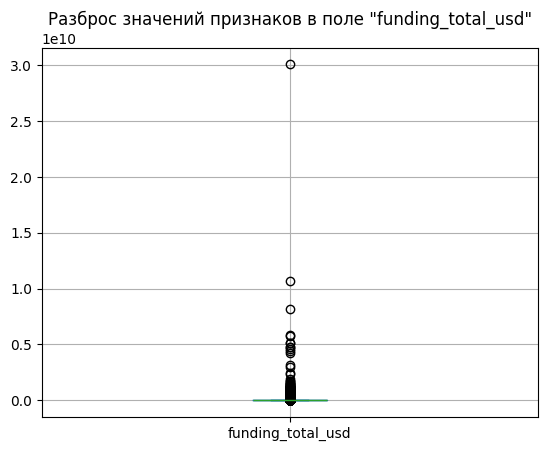

In [40]:
dataset['funding_total_usd'].plot(kind='box')
plt.title(f'Разброс значений признаков в поле "funding_total_usd"')
plt.grid(True)
plt.show();

Как показывает "ящик с усами" в данных действительно много выбросов, поэтому при заполнении данных используем медиану. 

Также из общих данных видно, что в компаниях может быть до 19 инвестиционных раундов. Можно предположить, что сумма привлеченных инвестиций зависит от количества раундов. 

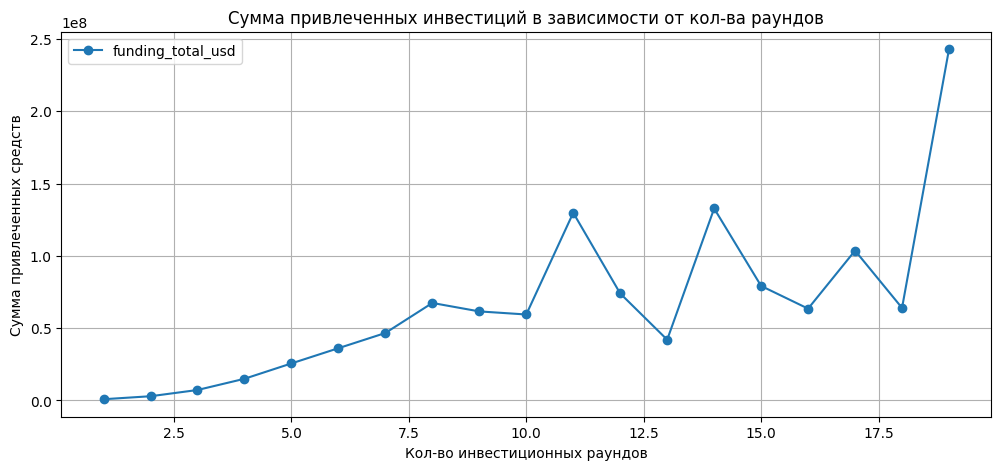

In [41]:
(dataset
     .pivot_table(index='funding_rounds', 
                  values='funding_total_usd',
                  aggfunc='median')
     .reset_index()
     .plot(xlabel='Кол-во инвестиционных раундов', ylabel='Сумма привлеченных средств',
          x='funding_rounds', 
          grid=True, style='o-', figsize=(12, 5), 
          title='Сумма привлеченных инвестиций в зависимости от кол-ва раундов')
);

Из графика видно, что с ростом количества раундов медианная сумма привлеченных средств изменяется. До 8 раундов сумма стабильно возрастает. Далее график нестабилен, что может быть связано с недостатком данных, т.к. стартапы редко имеют более 10 раундов. Заполним пропуски медианой по данным для каждого количества инвестиционных раундов.

In [42]:
for round in dataset['funding_rounds'].unique():
    dataset.loc[(dataset['funding_rounds'] == round) & (dataset['funding_total_usd'].isna()), 'funding_total_usd'] = \
    dataset.loc[dataset['funding_rounds'] == round, 'funding_total_usd'].median()

Удалим колонки, которые не будем использовать при обучении.

In [43]:
df_model = dataset.drop(columns=['category_list', 'country_code', 'state_code', 'region', 'city', 'closed_at'], axis=1)

In [44]:
#check
df_model.isna().sum()

name                     0
funding_total_usd        0
status                   0
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
categories               0
country_code_selected    0
state_code_selected      0
region_selected          0
city_selected            0
dtype: int64

<b>Вывод по разделу "Предобработка данных"</b>

В ходе предобработки:
- пропуски в колонке `closed_at` не заполнялись, т.к. это утечка данных. дата закрытия напрямую связана с целевой пременной и не может быть доступна на момент принятия решения об инвестировании в стартап.
- колонка `category_list` преобразована в `categories` в несколько этапов: 
    1. Пустые значения заменены на 'MISSING'
    2. Из комплексных значений в поле выделены отдельные категории, среи которых отобраны 70% наиболее часто встречаемых, остальные заменены на 'ELSE'. Количество уникальных значений снижено с 22106 до 29.
    3. Часть категорий "вручную" объединена в кластеры, отражающие укрупненно отрасль категории.
- колонки `country_code`, `state_code`, `region`, `city`:
    1. Проверены на наличие неявных дублей. Из данных удалены обнаруженные дубли в названии городов, связанные с различиями в написании.
    2. Пропуски заменены на 'MISSING'.
    3. Для каждого поля отобраны наиболее встречаемые значения (`country_code` - 95%, `state_code`, `region`, `city` - 70%), остальные значения заменены на 'ELSE'. Количество уникальных значений снижено: \
    `country_code` - со 135 до 25; \
    `state_code` - с 301 до 22; \
    `region` - с 1037 до 45; \
    `city` - с 4478 до 165. 
- в поле `funding_rounds` пропуски заполнены медианой по значениям для каждого количества инвестиционных раундов.

## Исследовательский анализ данных

### Категориальные признаки

Исследуем сперва категориальные переменные. Большинство категориальных признаков принимает большое количество значений, поэтому для визуализации подойдет столбчатая диаграмма. Чтобы график оставался читаемым оставим ТОП-25 значений для каждого поля, не включая пропущенные значений " MISSING" и укрупненные "ELSE".

In [45]:
def category_graph(data, columns):
    for column in columns:
        if len(data[column].unique()) <= 2:
            values = data.value_counts(column)
            ax = values.plot.pie(
                autopct=lambda x: f'{x:.1f}%\n({(x * sum(values) / 100).round(0)})',
                startangle=90,
                ylabel='',       
                title=f'Соотношение значений в поле "{column}"'
            )
            plt.show()
        elif len(data[column].unique()) > 25:
            ax = (data[(data[column] != 'missing') & (data[column] != 'else')]
                  .value_counts(column)
                  .head(25)
                  .plot.barh()
                  )
            plt.title(f'Столбчатая диаграмма распределения в поле "{column}"')
            plt.xlabel('Количество сотрудников')
            plt.ylabel('Значение')
            plt.show()
            
        else:
            ax = (data[(data[column] != 'missing') & (data[column] != 'else')]
                  .value_counts(column)
                  .plot.barh()
                  )
            plt.title(f'Столбчатая диаграмма распределения в поле "{column}"')
            plt.xlabel('Количество сотрудников')
            plt.ylabel('Значение')
            plt.show()

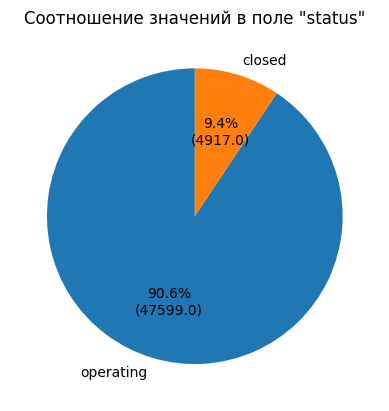

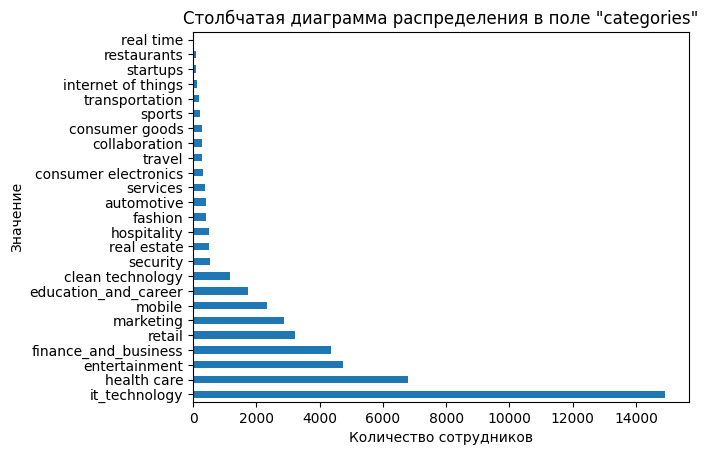

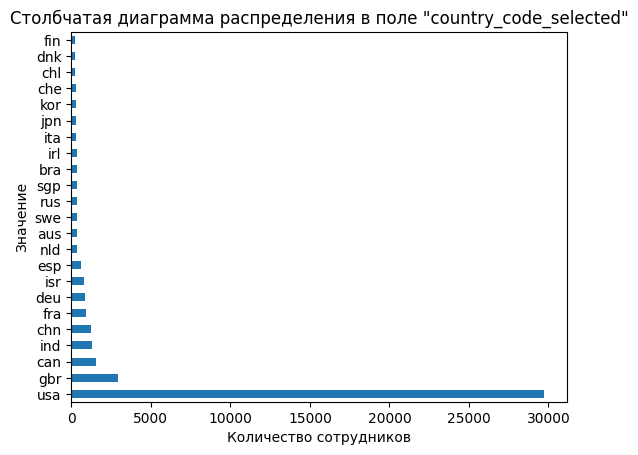

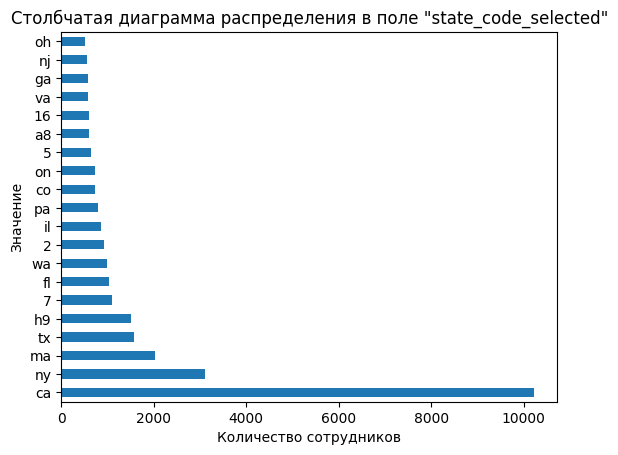

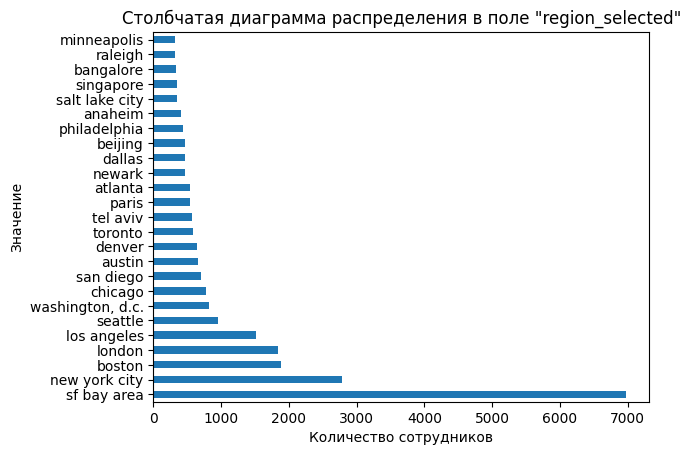

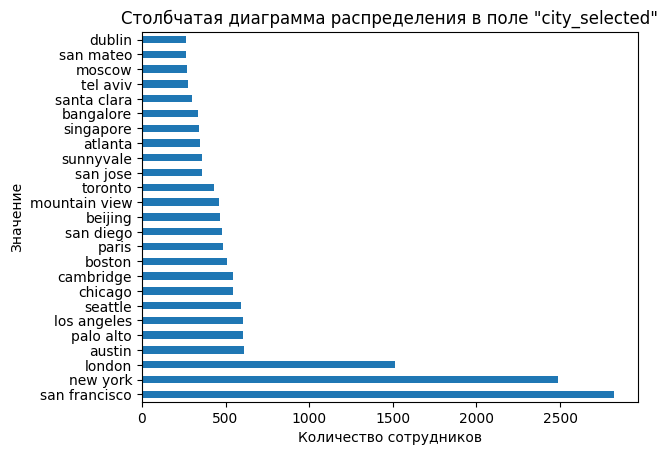

In [46]:
cat_columns = ['status', 'categories', 'country_code_selected', 'state_code_selected', 'region_selected', 'city_selected']
category_graph(df_model, cat_columns)

1. Поле `status` - целевая переменная. Количество закрытых стартапов составляет 9,4% (4917 шт) от общего числа наблюдений. В данном случае имеет место **дисбаланс классов**. При обучении модели имеет смысл использовать атрибут class_weights='balanced' где это возможно.

2. ТОП-3 категорий среди стартапов: IT-технологии, здравоохранение и медиа(развлечения). Больше всего стартапов расположено в США, причем лидируют Нью-йорк и Сан-Франциско. Что в целом ожидаемо, т.к. "силиконовая долина" широко известное место, которое привлекает как стартапы, так и инвесторов. Стоит отметить, что Индия и Китай вошли в ТОП-5 по количеству стартапов среди стран, обогнав все европейские страны, что может говорить об активном развитии технологий в этих странах. Москва входит в ТОП-25 городов по количеству стартапов. 

Из представленных данных можно составит "портрет" среднего стартапа: это компания в сфере IT, которая расположена в США, Сан-Франциско.

### Количественные признаки

Далее посмотрим на **количественные признаки.**

Чтобы проанализировать признаки связанные с датами, преобразуем их также в количественные.
У нас есть данные о дате основания компании, дате первого и последнего инвестиционного раунда. Создадим на их основе признаки:
1. `monthes_to_funding` -  период со времени основания компании до первого инвестиционного раунда (в днях). Эта информация покажет как быстро компания привлекла первые инвестиции.
2. `funding_period` - период между первым и последним инвестиционным раундом (в днях). Показывает как долго компания активно привлекала деньги.

Таким образом, мы охватим все признаки, связанные с датами, и сохраним полезные временные закономерности, потенциально полезные для прогнозирования. 

In [47]:
df_model['days_to_funding'] = df_model.apply(
    lambda row: (row['first_funding_at'] - row['founded_at']).days, axis=1
)
df_model[['days_to_funding', 'first_funding_at', 'founded_at']].head(2)

,days_to_funding,first_funding_at,founded_at
0,561,2011-05-01,2009-10-17
1,1949,2010-05-04,2005-01-01


In [48]:
df_model['funding_period'] = df_model.apply(
    lambda row: (row['last_funding_at'] - row['first_funding_at']).days, axis=1
)

df_model[['funding_period', 'last_funding_at', 'first_funding_at']].head(2)

,funding_period,last_funding_at,first_funding_at
0,1310,2014-12-01,2011-05-01
1,1393,2014-02-25,2010-05-04


In [49]:
def numeric_graph(data, num_columns):
    for column in num_columns:
        data[column].hist()
        plt.title(f'Гистограмма распределения в поле "{column}"')
        plt.xlabel('Значение')
        plt.ylabel('Количество сотрудников')
        plt.show()   
        
        data[column].plot(kind='box')
        plt.title(f'Разброс значений признаков в поле "{column}"')
        plt.grid(True)
        plt.show()

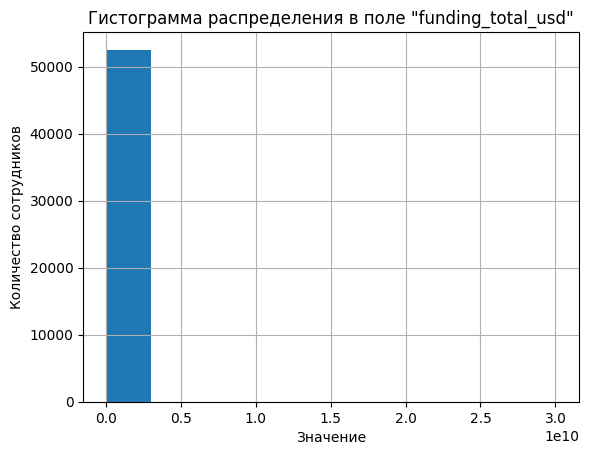

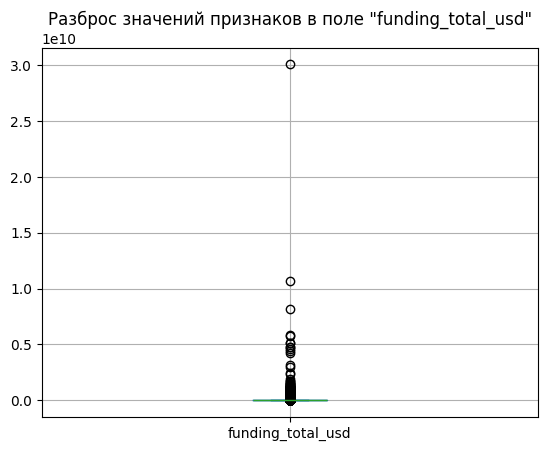

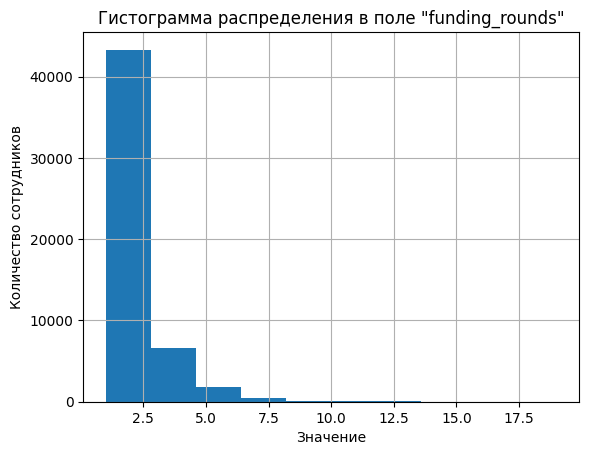

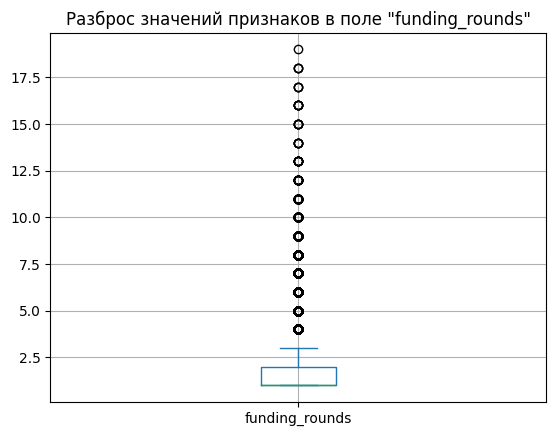

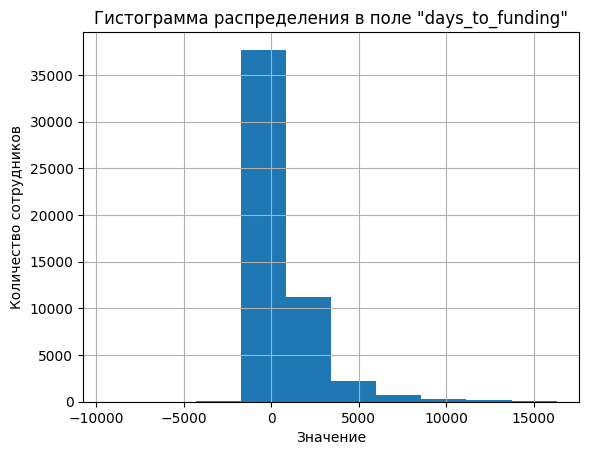

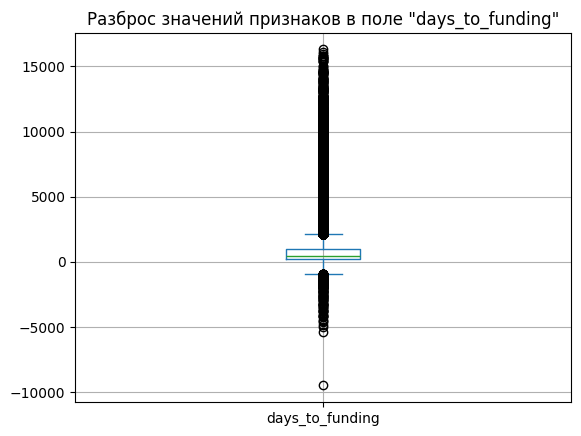

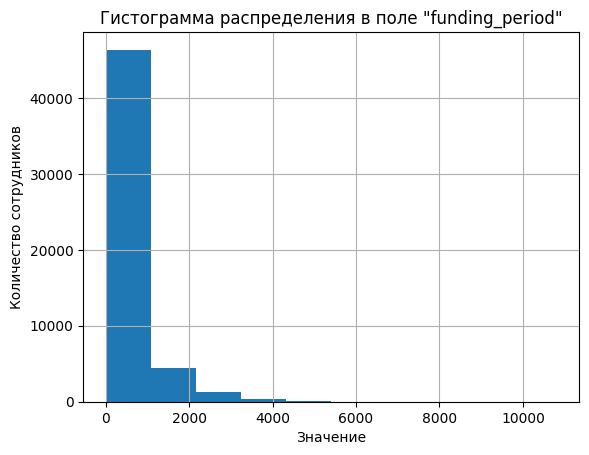

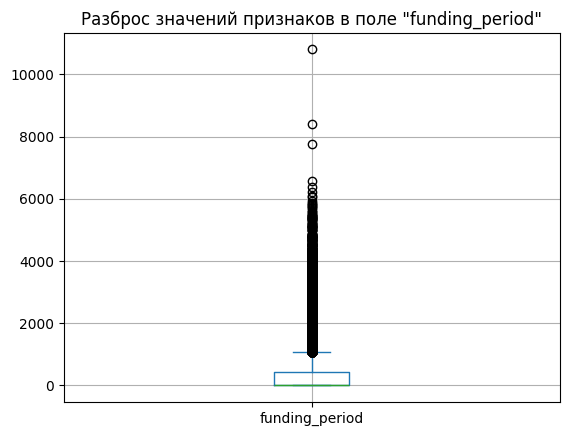

In [50]:
num_columns = ['funding_total_usd', 'funding_rounds', 'days_to_funding', 'funding_period']
numeric_graph(df_model, num_columns)

Среди количественных признаков нет ни одного с нормальным распределением, все имеют длинные "хвосты". Также во всех полях есть выбросы. Однако, в данном случае удалять их не будем. Стоит учесть компании, которые привлекли большую сумму денег или делают это продолжительный период, это своего рода "звезды" среди стартапов. 

Можно отметить, что часть компаний привлекла первые инвестиции до официального основания. Активный период привлечения инвестиций чаще всего составляет до 3 лет, а первые инвестиции компания привлекает в пределах 2-х лет от основания.

Большинство стартапов привлекли до 2 млн.долл. инвестиций в 1-2 раундах. Посмотрим на распределение в этих диапазонах внимательнее.

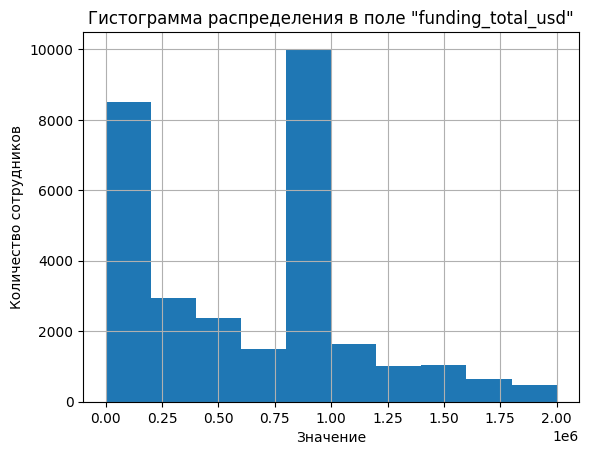

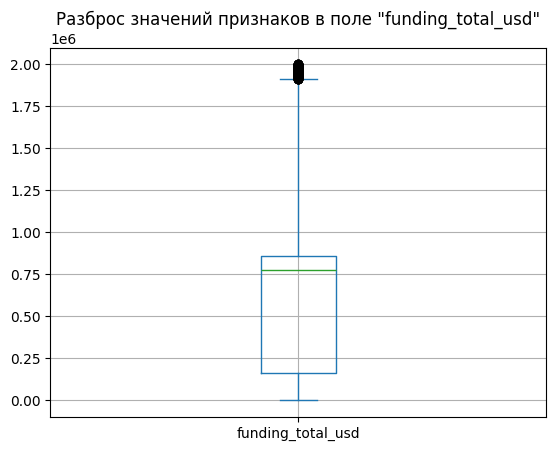

In [51]:
numeric_graph(df_model[df_model['funding_total_usd'] < 2000000], num_columns=['funding_total_usd'])

Распределение привлеченных инвестиций среди наиболее многочисленной группы до 2 млн.долл - бимодальное. Большая часть компаний привлекает от 750 тыс. до 1 млн.долл. Второй пик чуть меньше - это компании, которые привлекли до 250 тыс.долл. 

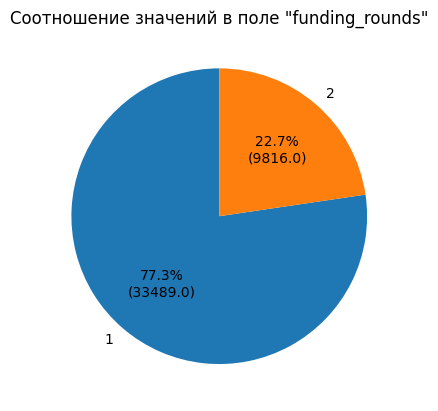

In [52]:
category_graph(df_model[df_model['funding_rounds'] <= 2], columns=['funding_rounds'])

Большинство компаний имело 1 инвестиционный раунд. Следовательно, можно предположить, что стартапы в среднем имеют 1 инвестиционный раунд (первичное размещение) и привлекают от 750 тыс до 1 млн.долл.

### Анализ закрывшихся компаний

Проанализруем признаки закрывшихся стартапов. Распределение категорий в данных неравномерное, поэтому нормализуем количество ушедших относительно исследуемого признака. Для этого внесем правки в изначальную функцию для отрисовки графиков.

In [53]:
def category_graph_normalize(data, columns):
    for column in columns:
        closed_ratio = (data[(data[column] != 'missing') & (data[column] != 'else')]
                            .groupby(column)['status']
                            .value_counts(normalize=True)
                            .unstack()['closed']
                            )
        closed_ratio = closed_ratio.fillna(0).sort_values(ascending=False).head(25)

        ax = closed_ratio.plot.barh()
        plt.title(f'Доля закрывшихся стартапов в поле "{column}"')
        plt.xlabel('Доля закрывшихся стартапов')
        plt.ylabel(column)
        plt.show()

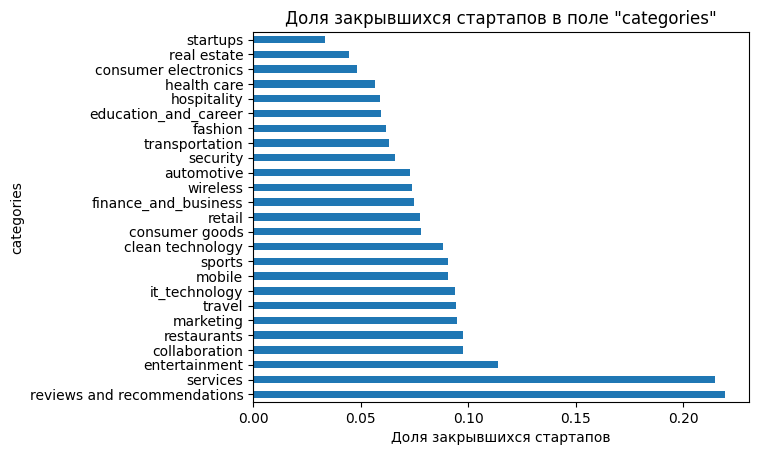

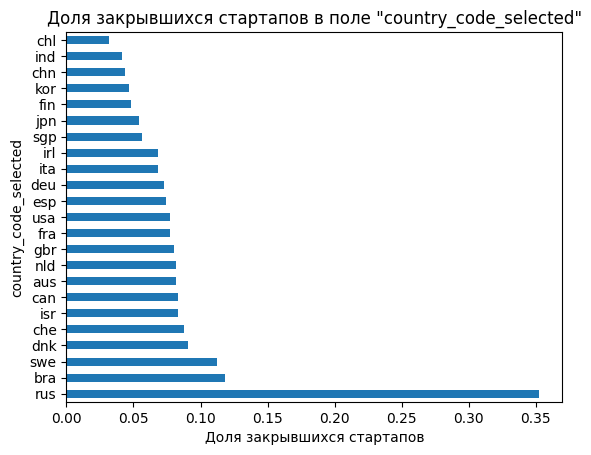

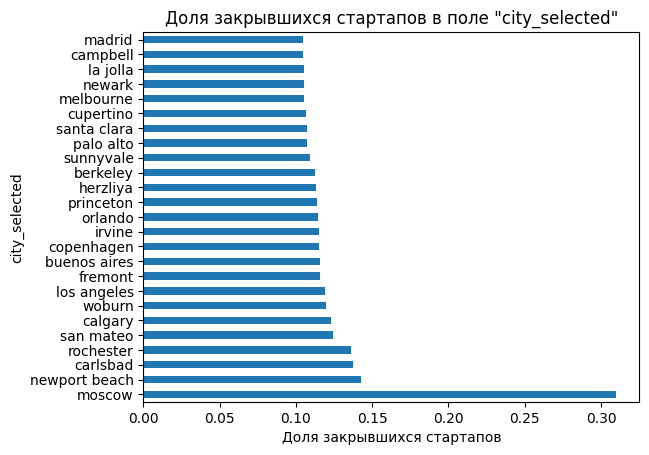

In [54]:
cat_columns = ['categories', 'country_code_selected',  'city_selected']
category_graph_normalize(df_model, cat_columns)

Самыми "опасными" с точки зрения инвестора, являются стартапы в категориях 'reviews and recommendations' и 'services'. В этих категориях закрывается свыше 20% стартапов. Риск закрытия выше 10% также в категории 'entertainment'. В остальных категориях количество закрывшихся стартапов меньше 10%. 

По географическому критерию наиболее рискованными являются стартапы из России (Москва). Доля закрывшихся стартапов здесь составляет более 30%. В категорию "рискованных" стран также можно отнести Бразилию и Швецию, в которых доля закрышихся стартапов ~ 10%.

In [55]:
df_closed = df_model.query('status == "closed"')
print(df_closed.shape[0])
df_operating = df_model.query('status == "operating"')
print(df_operating.shape[0])

4917
47599


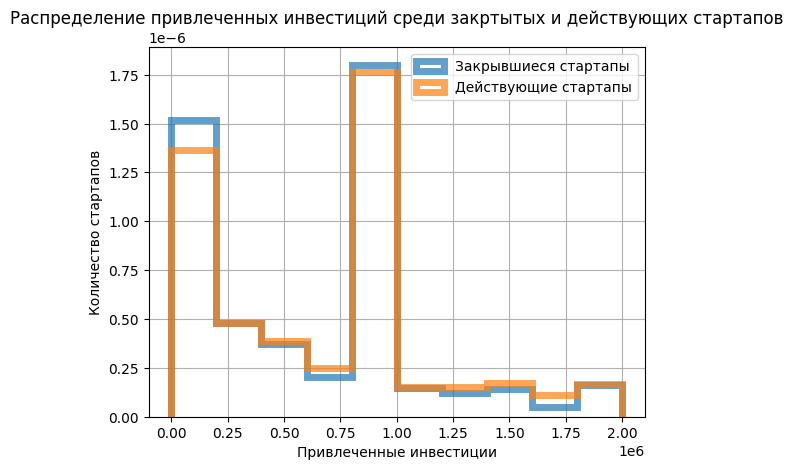

In [56]:
ax = df_closed[df_closed['funding_total_usd'] <= 2000000].plot(kind='hist', 
               y='funding_total_usd', 
               histtype='step',
               linewidth=5, 
               alpha=0.7, 
               label='Закрывшиеся стартапы',
               density=True 
              )

df_operating[df_operating['funding_total_usd'] <= 2000000].plot(kind='hist', 
          y='funding_total_usd', 
          histtype='step',
          linewidth=5, 
          alpha=0.7, 
          label='Действующие стартапы',
          ax=ax, 
          grid=True, 
          legend=True,
          density=True 
        )
plt.title('Распределение привлеченных инвестиций среди закртытых и действующих стартапов')
plt.xlabel('Привлеченные инвестиции')
plt.ylabel('Количество стартапов')
plt.show()

Распределение привлеченных средств для закрывшихся и действующих стартапов в наиболее частотном диапазоне (до 2 млн.долл.) практически не отличается. 

<b>Вывод по разделу "Исследовательский анализ данных"</b>

1. Исходя из найденных закономерностей в данных можно составить:
- **"портрет" среднего стартапа:** компания в сфере IT, которая расположена в США, Сан-Франциско. Участвующая как минимум в одном инвестиционном раунде и привлекшая до 1 млн.долл. в первые 2 года существования.
- **"портрет" закрывшегося стартапа:** компания в сферах рекоммендательных или развлекательных сервисов, расположенная в России (Москва). Также имевшая хотя бы один инвестиционный раунд с привлечением до 1 млн.долл.

2. В целевой переменной выявлен **дисбаланс классов**.

3. Для учета временных закономерностей созданы синтетические переменные:
- `days_to_funding` -  период со времени основания компании до первого инвестиционного раунда, мес. Показывает как быстро компания привлекла первые инвестиции.
- `funding_period` - период между первым и последним инвестиционным раундом, мес. Показывает как долго компания активно привлекала деньги.

3. Данные распределены ненормально, что важно учитывать при корреляционном анализе. В данных присутствуют выбросы, однако, в данном случае принято решение их сохранить, т.к. это специфика данных.

## Корреляционный анализ

Изучим взамосвязь между признаками в тренировочной выборке и рассчитаем коэффициенты корреляции. Т.к. у нас в данных большое количество категориальных признаков, используем коэффициент корреляции Фи. Для наглядности построим тепловую карту.

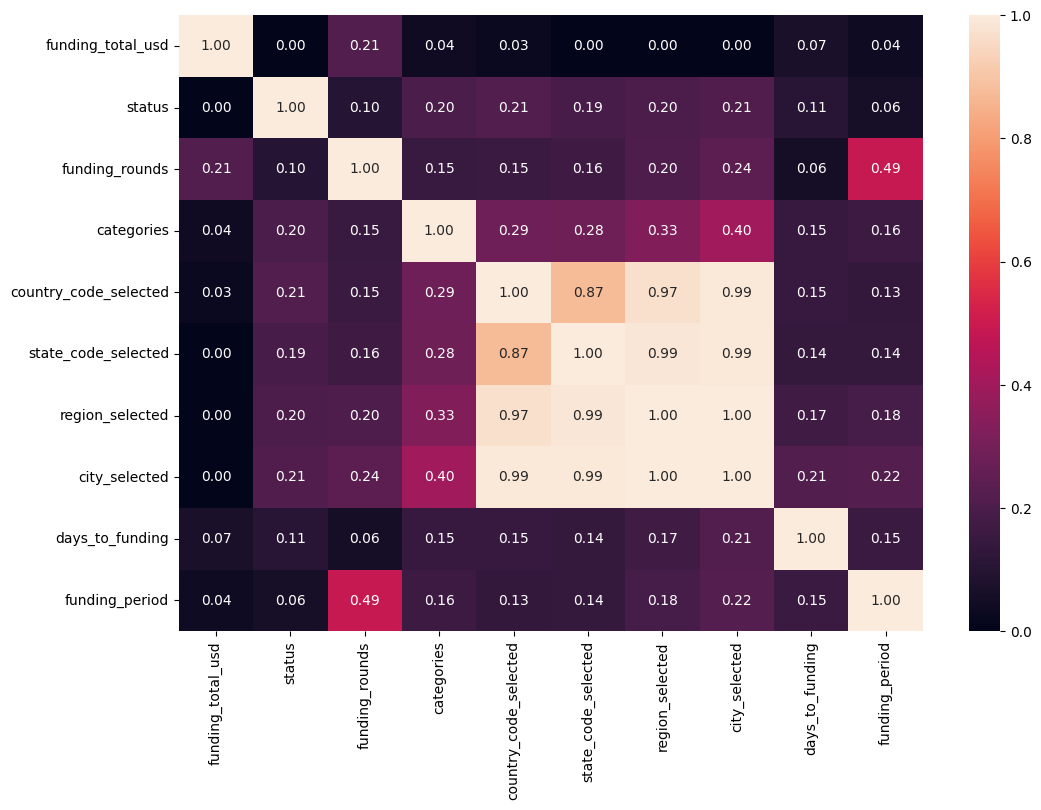

In [57]:
correlate_col = ['funding_total_usd', 'status', 'funding_rounds', 'categories', 'country_code_selected', \
                  'state_code_selected', 'region_selected', 'city_selected', \
                  'days_to_funding', 'funding_period']

plt.figure(figsize=(12, 8))
sns.heatmap(df_model[correlate_col].phik_matrix(interval_cols=num_columns), annot=True, fmt='.2f')
plt.show();

Как правило, о мультиколлинеарности говорят при значении коэффициента от 0.9 по модулю. В наших данных таких значений несколько: все географические признаки сильно коррелируют между собой, что логично, т.к. между ними действительно есть сильная взаимосвязь: регион как и город относится к конкретной стране. Чтобы избежать мультиколлинеарности оставим в данных поле `country_code_selected`, т.к. оно максимально сохраняет информативность при небольшом количестве отобранных уникальных значений.

Cудя по тепловой карте, ни один из признаков не имеет сильной корреляции с целевым признаком. 

Удалим признаки, которые не будем использовать при обучении модели, включая поле `name`.

In [58]:
df_model = df_model.drop(columns=['state_code_selected', 'region_selected', 'city_selected', \
                                  'founded_at', 'first_funding_at', 'last_funding_at', 'name'], axis=1)
df_model.head(2)

,funding_total_usd,status,funding_rounds,categories,country_code_selected,days_to_funding,funding_period
0,"828,626.000",operating,2,restaurants,che,561,1310
1,"42,935,019.000",operating,4,finance_and_business,usa,1949,1393


После удаления "лишних" колонок еще раз проверяем данные на явные дубликаты. Полностью идентичные строки не несут полезной информации для модели, поэтому корректнее из удалить.

In [59]:
print(df_model.shape)
df_model = df_model.drop_duplicates()
print(df_model.shape)

(52516, 7)
(51249, 7)


<b>Вывод по разделу "Корреляционный анализ"</b>

- Обнаружена мультиколлинеарность между признаками указывающими на географическое положение стартапа. В датасете оставлено поле `country_code_selected`, как наиболее информативное при минимальном количестве уникальных значений. В этом поле изначально было меньше всего пропущенных значений, при проверке не было выявлено разночтений или ошибок в значениях, а также при отборе значений для снижения размерности удалось сохранить 95% значений данных при небольшой размерности.

- Ни один из признаков не имеет сильной корреляции с целевым. Дополнительных утечек данных не выявлено.

## Подготовка данных и разработка модели

Т.к. на этапе исследовательского анализа мы отметили, что в целевой переменной присутствует дисбаланс классов, при разбиении данных будем использовать стратифицированные выборки. 

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    df_model.drop(['status'], axis=1),
    df_model['status'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_model['status'])

In [61]:
print('Размер тренировочной выборки', X_train.shape)
print('Размер тестовой выборки', X_test.shape)

Размер тренировочной выборки (38436, 6)
Размер тестовой выборки (12813, 6)


Закодируем предварительно целевой признак, т.к. метод ColumnTransformer его не преобразовывает. Для целевого признака используем `LabelEncoder`

In [62]:
label_encoder = LabelEncoder()
y_train_transform = label_encoder.fit_transform(y_train)
y_test_transform = label_encoder.transform(y_test)

In [63]:
label_encoder.inverse_transform(y_train_transform)

array(['operating', 'operating', 'operating', ..., 'operating',
       'operating', 'operating'], dtype=object)

In [64]:
y_train.value_counts()

status
operating    34831
closed        3605
Name: count, dtype: int64

In [65]:
y_train_transform.sum()

np.int64(34831)

Переходим к подготовке пайплайна для предобработки признаков. Подготовим списки с названиями признаков, разделенные по предполагаемому методу обработки. В данных нет категориальных признаков, которые можно прорандировать, поэтому используем   OneHotEncoder. 

In [66]:
ohe_columns = ['categories', 'country_code_selected']
num_columns = X_train.select_dtypes(include='number').columns.tolist()

Подготовим пайплайн для обработки пропущенных значений энкодерами. Для энкодера установим параметр handle_unknown, который позволяет обрабатывать неизвестные категории при необходимости и присваивать им нулевое значение. 

In [67]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

Создаем общий пайплайн для подготовки данных: применяем каждый ранее созданный пайплайн к соответствующим колонкам. Для моделей градиентного бустинга масштабирование не так важно, но для выбора лучшей модели планируется попробовать различные варианты, включая линейные модели, поэтому к количественным признакам применим масштабирование. 

In [68]:
data_preprocessor = ColumnTransformer(
    [ 
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

Подготовим пайплан для обучения модели (используем модель DecisionTreeClassifier). Итоговый пайплайн включает 2 шага: 

1. Подготовка данных — шаг preprocessor.
2. Инициализация модели DecisionTreeClassifier — шаг models.

In [69]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
) 

Дл масштабирования будем использовать два скейлера: `StandardScaler()` и `MinMaxScaler()` + без масштабирования. Зададим варианты масшабирования как гиперпараметр. В дальнейшем для логистической регрессии не будем включать метод без масштабирования, чтобы избежать ситуации когда модель не сходится из-за разброса значений признаков.

In [70]:
param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
} 

Чтобы найти лучшее решение обучим 4 разных модели: 
- DecisionTreeClassifier()
- LogisticRegression()
- CatBoostClassifier()
- LGBMClassifier()
Для каждой подберем гиперпараметры. Для удобства перебор моделей осуществим внутри пайплайна. Для моделей, которые поддерживают этот метод добавим class_weights='balanced'. 

In [71]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE,
                                          class_weight='balanced')],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            class_weight='balanced',
            solver='saga', 
            penalty='elasticnet',
            max_iter=3000
        )],
        'models__C': range(2, 10),
        'models__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    # Словарь для CatBoostClassifier
    {
        'models': [CatBoostClassifier(
            random_state=RANDOM_STATE,
            auto_class_weights='Balanced',
            silent=True  
        )],
        'models__depth': range(4, 10),
        'models__learning_rate': uniform(0.01, 0.05),
        'models__l2_leaf_reg': range(1, 10),  
        'preprocessor__num': ['passthrough']
    },
    # Словарь для LGBMClassifier
    {
        'models': [LGBMClassifier(
            random_state=RANDOM_STATE,
            class_weight='balanced',
            n_jobs=-1,
            verbose=-1  
        )],
        'models__max_depth': range(4, 10),         
        'models__learning_rate': uniform(0.01, 0.05),
        'models__num_leaves': range(2, 40),   
        'models__reg_alpha': uniform(0.01, 0.03),    
        'models__reg_lambda': uniform(0.01, 0.03),     
        'preprocessor__num': ['passthrough']
    }
]

В соответствии с условиями заказчика в качестве метрики будем использовать F1-score.

In [72]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid, 
    cv=5,
    scoring='f1', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [73]:
randomized_search.fit(X_train, y_train_transform)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='constant')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['categories',
                                                                                'country_code_selected']),
                                                                              ('num...
                                         'models__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x13aa1a710>,
                                         'models__max_depth': range(4, 10),
                                         'models__num_leaves': range(2, 40),
                                         'models__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x13aa1a990>,
                                         'models__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x13a644c30>,
                                         'preprocessor__num': ['passthrough']}],
                   random_state=42, scoring='f1')

In [74]:
print('Метрика f1-score для лучшей модели:\n', randomized_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('\nЛучшие параметры\n\n', randomized_search.best_params_)

Метрика f1-score для лучшей модели:
 0.861782882639166

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['categories',
                     

In [75]:
result = pd.DataFrame(randomized_search.cv_results_)
(result[['rank_test_score', 'param_models', 'mean_test_score','params']]
                                        .sort_values('rank_test_score')
                                        .head()
)

,rank_test_score,param_models,mean_test_score,params
3,1,<catboost.core.CatBoostClassifier object at 0x13a510c20>,0.862,"{'models': <catboost.core.CatBoostClassifier object at 0x13a510c20>, 'models__depth': 9, 'models__l2_leaf_reg': 5, 'models__learning_rate': 0.05849549260809972, 'preprocessor__num': 'passthrough'}"
0,2,<catboost.core.CatBoostClassifier object at 0x13a510c20>,0.830,"{'models': <catboost.core.CatBoostClassifier object at 0x13a510c20>, 'models__depth': 7, 'models__l2_leaf_reg': 8, 'models__learning_rate': 0.03993292420985183, 'preprocessor__num': 'passthrough'}"
8,3,<catboost.core.CatBoostClassifier object at 0x13a510c20>,0.823,"{'models': <catboost.core.CatBoostClassifier object at 0x13a510c20>, 'models__depth': 5, 'models__l2_leaf_reg': 4, 'models__learning_rate': 0.05711008778424264, 'preprocessor__num': 'passthrough'}"
2,4,<catboost.core.CatBoostClassifier object at 0x13a510c20>,0.821,"{'models': <catboost.core.CatBoostClassifier object at 0x13a510c20>, 'models__depth': 8, 'models__l2_leaf_reg': 4, 'models__learning_rate': 0.01714334089609704, 'preprocessor__num': 'passthrough'}"
6,5,<catboost.core.CatBoostClassifier object at 0x13a510c20>,0.820,"{'models': <catboost.core.CatBoostClassifier object at 0x13a510c20>, 'models__depth': 6, 'models__l2_leaf_reg': 3, 'models__learning_rate': 0.029123099563358137, 'preprocessor__num': 'passthrough'}"


In [76]:
y_test_pred = randomized_search.predict(X_test)

In [77]:
print(f'Метрика F1-score на тестовой выборке: {f1_score(y_test_transform, y_test_pred)}')

Метрика F1-score на тестовой выборке: 0.860924683072334


<b>Вывод по разделу "Подготовка данных и разработка модели"</b>

В ходе работы над разделом подготовлен пайплайн:
- данные разделены на тренировочную и тестовую выборку со стратификацией по целевому признаку
- целевой признак закодирован с помощью LabelEncoder
- для обработки категориальных переменных использовался OneHotencoder
- для масштабирования количественных признаков использованы 3 разных метода в зависимости от модели: StandardScaler, MinMaxScaler, без масштабирования
- для поиска лучшего решения были обучены 4 разных модели с подбором гиперпараметров: DecisionTreeClassifier(), LogisticRegression(), CatBoostClassifier() и LGBMClassifier(). Перебор осуществлялся методом RandomizedSearchCV. 
- Для оценки качества использовалась метрика F1_score (среднее гармоническое между precision и recall).

Лучшая модель - `CatBoostClassifier` со взвешенными классами и параметрами: 'models__depth': 9, 'models__l2_leaf_reg': 5, 'models__learning_rate': 0.05849549260809972, 'preprocessor__num': 'passthrough'

Метрика F1-score для лучшей модели при кросс-валидации: 0.861782882639166

Метрика F1-score на тестовой выборке: 0.860924683072334

### Анализ важности признаков

Оценим важность признаков для лучшей модели. Это поможет интерпретировать результаты модели и подготовить рекомендации для заказчика. Для этого построим график важности признаков с помощью метода SHAP. Предварительно нужно повторить обработку датасета для подачи методу через тот же пайплайн.

In [78]:
best_preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']

X_train_transformed = pd.DataFrame(
    best_preprocessor.transform(X_train),  
    columns=best_preprocessor.get_feature_names_out()
)

X_test_transformed = pd.DataFrame(
    best_preprocessor.transform(X_test),
    columns=best_preprocessor.get_feature_names_out()
)

In [79]:
display(X_train_transformed.head(2))
display(X_test_transformed.head(2))

,ohe__categories_clean technology,ohe__categories_collaboration,ohe__categories_consumer electronics,ohe__categories_consumer goods,ohe__categories_education_and_career,ohe__categories_else,ohe__categories_entertainment,ohe__categories_fashion,ohe__categories_finance_and_business,ohe__categories_health care,ohe__categories_hospitality,ohe__categories_internet of things,ohe__categories_it_technology,ohe__categories_marketing,ohe__categories_missing,ohe__categories_mobile,ohe__categories_real estate,ohe__categories_real time,ohe__categories_restaurants,ohe__categories_retail,ohe__categories_reviews and recommendations,ohe__categories_security,ohe__categories_services,ohe__categories_sports,ohe__categories_startups,ohe__categories_transportation,ohe__categories_travel,ohe__categories_wireless,ohe__country_code_selected_bra,ohe__country_code_selected_can,ohe__country_code_selected_che,ohe__country_code_selected_chl,ohe__country_code_selected_chn,ohe__country_code_selected_deu,ohe__country_code_selected_dnk,ohe__country_code_selected_else,ohe__country_code_selected_esp,ohe__country_code_selected_fin,ohe__country_code_selected_fra,ohe__country_code_selected_gbr,ohe__country_code_selected_ind,ohe__country_code_selected_irl,ohe__country_code_selected_isr,ohe__country_code_selected_ita,ohe__country_code_selected_jpn,ohe__country_code_selected_kor,ohe__country_code_selected_missing,ohe__country_code_selected_nld,ohe__country_code_selected_rus,ohe__country_code_selected_sgp,ohe__country_code_selected_swe,ohe__country_code_selected_usa,num__funding_total_usd,num__funding_rounds,num__days_to_funding,num__funding_period
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,"50,000,000.000",1.000,359.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,"7,704,120.000",4.000,"1,049.000","1,006.000"


,ohe__categories_clean technology,ohe__categories_collaboration,ohe__categories_consumer electronics,ohe__categories_consumer goods,ohe__categories_education_and_career,ohe__categories_else,ohe__categories_entertainment,ohe__categories_fashion,ohe__categories_finance_and_business,ohe__categories_health care,ohe__categories_hospitality,ohe__categories_internet of things,ohe__categories_it_technology,ohe__categories_marketing,ohe__categories_missing,ohe__categories_mobile,ohe__categories_real estate,ohe__categories_real time,ohe__categories_restaurants,ohe__categories_retail,ohe__categories_reviews and recommendations,ohe__categories_security,ohe__categories_services,ohe__categories_sports,ohe__categories_startups,ohe__categories_transportation,ohe__categories_travel,ohe__categories_wireless,ohe__country_code_selected_bra,ohe__country_code_selected_can,ohe__country_code_selected_che,ohe__country_code_selected_chl,ohe__country_code_selected_chn,ohe__country_code_selected_deu,ohe__country_code_selected_dnk,ohe__country_code_selected_else,ohe__country_code_selected_esp,ohe__country_code_selected_fin,ohe__country_code_selected_fra,ohe__country_code_selected_gbr,ohe__country_code_selected_ind,ohe__country_code_selected_irl,ohe__country_code_selected_isr,ohe__country_code_selected_ita,ohe__country_code_selected_jpn,ohe__country_code_selected_kor,ohe__country_code_selected_missing,ohe__country_code_selected_nld,ohe__country_code_selected_rus,ohe__country_code_selected_sgp,ohe__country_code_selected_swe,ohe__country_code_selected_usa,num__funding_total_usd,num__funding_rounds,num__days_to_funding,num__funding_period
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,"860,000.000",1.000,182.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,"25,000.000",1.000,498.000,0.000


In [80]:
explainer = shap.TreeExplainer(randomized_search.best_estimator_[-1])
shap_values = explainer(X_test_transformed)

Для начала посмотрим на вклад всех признаков в результат предсказания каждого наблюдения.

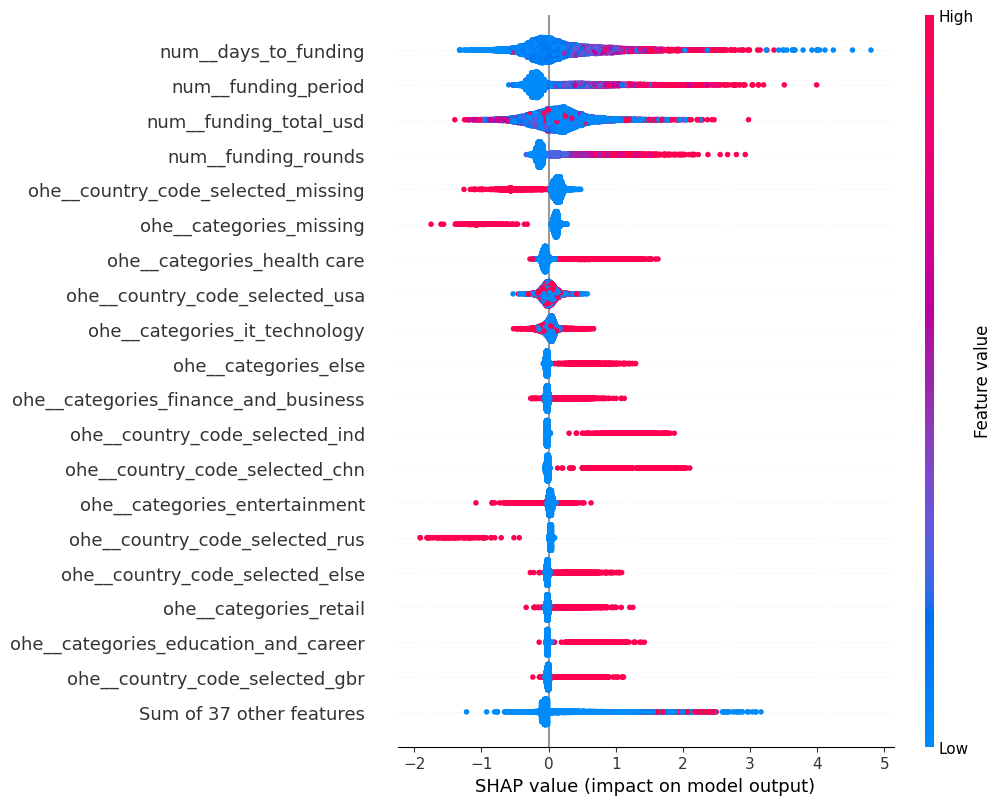

In [81]:
shap.plots.beeswarm(shap_values, max_display=20)

Из графика видно влияние следующих полей: 
1. `num__days_to_funding` (дней до получения инвестиций): чем меньше дней (синий, слева), тем выше вероятность успеха стартапа. Долгое ожидание инвестиций (красный) связано с закрытием.

2. `num__funding_period`, `num__funding_total_usd`, `num__funding_rounds`: высокие значения (красный) имеют положительное влияние на предсказание 1 (status = 'operating'). Больше раундов, денег и длительный инвестиционный период — признаки живого стартапа.

3. `ohe__categories_health care`, `ohe__categories_it_technology`, `ohe__categories_finance_and_business`: наличие этих категорий повышает шанс выживания стартапа, что подтверждает выводы, сделанные при анализе данных.

4. Стартапы из США и Индии чаще успешны. Стартапы из России и "прочих" стран чаще закрываются.

<b>Вывод по разделу "Анализ важности признаков"</b>

Анализ важности признаков с помощью SHAP показал, что на вероятность функционирования стартапа наибольшее положительное влияние оказывают факторы, связанные с инвестиционной активностью:
- меньшее время до получения первого финансирования, 
- больший объем привлеченных средств 
- количество раундов. 
Также положительный вклад вносят стартапы, зарегистрированные в США и Индии, а также проекты в сферах здравоохранения, информационных технологий и финансов. 

В то же время наличие пропусков в данных, принадлежность к категориям "развлечения", "образование и карьера", "ритейл", а также стартапы из России и других менее представленных стран — коррелируют с повышенным риском закрытия. 

Таким образом, **модель делает акцент на зрелости стартапа, инвестиционной поддержке и географической принадлежности**.

<b>Общий вывод по итогам разработки модели предсказания закрытия стартапа:</b>

Разработана модель для предсказания закрытия стартапа на текущий момент. На основании результатов модели проведён анализ наиболее значимых факторов, влияющих на вероятность закрытия компании. Полученные выводы и рекомендации могут быть использованы для оценки рисков при принятии инвестиционных решений.

Лучшая модель:
CatBoostClassifier с параметрами:
'depth': 9, 'l2_leaf_reg': 5, 'learning_rate': 0.0585, class_weights = 'balanced'.
Метрика F1-score на кросс-валидации: 0.8618
Метрика F1-score на тестовой выборке: 0.8609

Среди признаков, оказывающих наибольшее влияние на вероятность функционирования стартапа, выделены:

- `days_to_funding`: чем быстрее стартап получил первое финансирование, тем выше вероятность его текущего функционирования;

- `funding_rounds` и `funding_total_usd`: стартапы, привлекшие больше денег и участвовавшие в большем количестве раундов инвестиций, имеют больше шансов остаться на рынке;

- География: стартапы, зарегистрированные в странах с развитой венчурной экосистемой (например, США, Индия), демонстрируют лучшие результаты;

- Отрасль: проекты в сфере информационных технологий, здравоохранения и финансов имеют более высокие шансы на выживание.

**Рекомендации**:

Оценивать зрелость и динамику развития стартапа по временным метрикам: особенно важно учитывать скорость привлечения первых инвестиций и длительность инвестиционной активности. Эти показатели оказывают заметное влияние на жизнеспособность проектов.

Принимать во внимание отраслевую принадлежность и региональную специфику: стартапы в IT, финансах и медицине, а также зарегистрированные в США и Индии, имеют более высокую устойчивость.

Фокусироваться на объемах финансирования: компании, привлекшие больше средств, демонстрируют более стабильное функционирование, особенно при наличии нескольких раундов.

Модель выявляет наиболее перспективные стартапы по инвестиционным и географическим признакам. Это может быть полезно для создания системы предварительного скоринга при анализе инвестиционных заявок.

### Подготовка отложенной выборки 

In [83]:
dataset_test = pd.read_csv('data/kaggle_startups_test_28062024.csv', parse_dates=['first_funding_at',
                                                                                  'last_funding_at'])
display(dataset_test.head(2))
dataset_test.info()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,"2,819,200.000",NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


In [84]:
dataset_test[dataset_test['funding_rounds'] > 1].head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
2,COINPLUS,Finance,"428,257.000",LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,"34,700,000.000",USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
5,Quickfire Games,Design|Entertainment|Games,"160,000.000",NaN,NaN,NaN,NaN,2,2013-09-18,2014-09-18,1583
6,Sente Inc.,Biotechnology,"26,842,000.000",USA,CA,San Diego,Encinitas,5,2009-01-31,2014-06-02,4018
8,Urgent.ly,Software,"8,710,000.000",USA,VA,"Washington, D.C.",Sterling,3,2014-04-17,2015-09-29,1826


В отложенной выборке нет поля `founded_at`, однако, есть поле `lifetime`, которое, вероятно, отражает период существования стартапа в днях от момента выгрзуки данных. Мы знаем, что данные представлены по 2018 года (соответстевнно за дату выгрузки можно принять 2018-01-01). Из анализа тренировочной выборки мы знаем, что первые инвестиции привлекались в диапазоне 1,5-2 лет от создания. Выборочная ручная проверка показала, что скорее всего `lifetime` рассчитан именно по этому временному диапазону. 

In [85]:
dataset_test['founded_at'] = pd.to_datetime('2018-01-01') - pd.to_timedelta(dataset_test['lifetime'], unit='D')
dataset_test[['founded_at', 'first_funding_at', 'lifetime']].head(2)

,founded_at,first_funding_at,lifetime
0,2008-06-01,2009-07-01,3501
1,2010-07-25,2010-07-28,2717


Повторим предобработку для всех полей, которые мы отобрали в модель.

In [86]:
dataset_test['category_list'].fillna('MISSING', inplace=True)
dataset_test['categories'] = dataset_test['category_list'].str.lower().str.split('|').astype('object')
dataset_test[['categories', 'category_list']].head(2)

,categories,category_list
0,[clean technology],Clean Technology
1,[hospitality],Hospitality


In [87]:
dataset_test = bigger_categories(dataset_test, column='categories', categories= selected_categories)
dataset_test['categories'] = dataset_test['categories'].replace(reverse_category_mapping)
display(dataset_test[['categories', 'category_list']].head(2))
print('Кол-во уникальных значений в поле `categories:`', len(dataset_test['categories'].unique()))

,categories,category_list
0,clean technology,Clean Technology
1,hospitality,Hospitality


Кол-во уникальных значений в поле `categories:` 29


In [88]:
dataset_test['country_code'] = dataset_test['country_code'].str.lower()
dataset_test['country_code'].fillna('missing', inplace=True)


dataset_test['country_code_selected'] = dataset_test['country_code'].apply(
        lambda x: x if x in selected_categories_geo['country_code'] else 'ELSE'
    )
    
display(dataset_test.head(2))
print('Кол-во уникальных значений в поле `country_code_selected:`', \
      len(dataset_test['country_code_selected'].unique()))

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,founded_at,categories,country_code_selected
0,Crystalsol,Clean Technology,"2,819,200.000",nic,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,2008-06-01,clean technology,ELSE
1,JBI Fish & Wings,Hospitality,NaN,usa,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,2010-07-25,hospitality,usa


Кол-во уникальных значений в поле `country_code_selected:` 25


In [89]:
for round in dataset_test['funding_rounds'].unique():
    dataset_test.loc[(dataset_test['funding_rounds'] == round) & (dataset_test['funding_total_usd'].isna()), 'funding_total_usd'] = \
    dataset_test.loc[dataset_test['funding_rounds'] == round, 'funding_total_usd'].median()

In [92]:
dataset_test['days_to_funding'] = dataset_test.apply(
    lambda row: (row['first_funding_at'] - row['founded_at']).days, axis=1
)
display(dataset_test[['founded_at', 'first_funding_at', 'days_to_funding']].head(2))


dataset_test['funding_period'] = dataset_test.apply(
    lambda row: (row['last_funding_at'] - row['first_funding_at']).days, axis=1
)
display(dataset_test[['funding_period', 'last_funding_at', 'first_funding_at']].head(2))

,founded_at,first_funding_at,days_to_funding
0,2008-06-01,2009-07-01,395
1,2010-07-25,2010-07-28,3


,funding_period,last_funding_at,first_funding_at
0,0,2009-07-01,2009-07-01
1,0,2010-07-28,2010-07-28


In [93]:
best_pipeline = randomized_search.best_estimator_
best_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['categories',
                                                   'country_code_selected']),
                                                 ('num', 'passthrough',
                                                  ['funding_total_usd',
                                                   'funding_rounds',
                                                   'days_to_funding',
                                                   'funding_period'])])),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x13aa1b4d0>)])

In [94]:
y_pred_dataset_test = best_pipeline.predict(dataset_test)
y_pred_dataset_test = pd.Series(y_pred_dataset_test)
y_pred_dataset_test.tail(5)

13120    1
13121    0
13122    1
13123    1
13124    1
dtype: int64

In [95]:
y_pred_dataset_test.value_counts()

1    10096
0     3029
Name: count, dtype: int64

In [96]:
# Обновляем индекс, объединяем результаты и переименовываем столбцы
dataset_test = dataset_test.reset_index()

dataset_test_submit = pd.concat([dataset_test['name'],y_pred_dataset_test], axis=1)
dataset_test_submit.columns = ['name','status']

# Применяем функцию для преобразования 1 и 0 в operating, closed
dataset_test_submit['status'] = dataset_test_submit['status'].apply(lambda _: 'operating' if _ == 1 else 'closed')
dataset_test_submit.tail(5)

,name,status
13120,Jymob,operating
13121,GlobaTrek,closed
13122,Inkd.com,operating
13123,AdWill,operating
13124,RingCentral,operating


In [97]:
dataset_test_submit.to_csv('sample_scored.csv', index=False)
dataset_test_submit['status'].value_counts()

status
operating    10096
closed        3029
Name: count, dtype: int64